<a id='Contents'></a>

# Table of Contents

* [About the NoteBook](#about)
* [Quantization](#Quantization)
* [Product Quantization](#ProductQuantization)
    * [PQ performance](#PQperformance)
* [Importing dataset](#dt)
    * [Missing values](#Missing)
    * [Describe the dataframe](#Describe)
    * [Model input](#Input)
        * [Input Scaling](#Scaling)
* [Output Quantization](#OutputQuantization)
    * [list of identifiers](#identifiers)
    * [Multi-Label Classification](#MultiLabelML)
    * [Model evaluation](#Modelevaluation)
        * [with code words](#withcodewords)
        * [with real values](#withrealvalues)
            * [Decoding](#Decode)
            * [RMSE](#RMSE)
* [Conclusion](#Conclusion)
* [References](#References)


# License
This [Notebook](https://www.kaggle.com/code/samanemami/product-quantizing-the-output-space) has been released under the [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0) open source license.

<a id='about'></a>
# About the Notebook
[Table of Contents](#Contents)

In this notebook, I applied a novel quantization approach called product quantization. The purpose of this study was to reduce the output space of the model with a proper quantizer and transform a multi-output regression model into a multi-label classification model in which the output would be the identifiers of the quantized space.

The main idea of this notebook is based on the Multi-target regression via output space quantization paper [[1]](#References).

You can find the definition of each used model in the notebook as well.

The details of each part is added in the relevant cell.


Code Author: [Seyedsaman Emami](https://samanemami.github.io/)

<a id='Quantization'></a>
# Quantization
[Table of Contents](#Contents)

Quantization in the Machine Learning area refers to data compression. In simple words, it transforms the float points into the integers data types with the lowest precision. Therefore, the model training would be faster than before with this dimension reduction.

The opposite of quantization is dequantization which converts the transformed data into higher precision with higher bits. 

From the mathematical point of view, quantization is transforming a vector space into a set of finite values, where each value is the representer of the corresponding vector.


Code Author: [Seyedsaman Emami](https://samanemami.github.io/)

<a id='ProductQuantization'></a>
# Product Quantization
[Table of Contents](#Contents)

Product Quantization is introduced by [[2]](#References), which has a better performance in dealing with higher dimensions. The idea is to break down the vector space into the $m$ non-overlapping subvectors with dimensionality of $d' = \frac{d}{m}$.

> Note that this approach is more suitable for a higher-dimensions quantizer training set.

The product quantization is less complex than the [KMeans](https://www.kaggle.com/code/samanemami/a-comprehensive-introduction-to-kmeans) (Lloyd’s algorithm) and leads to more size reduction. 


<hr>

For instance, imagine that we have transformed a vector with a shape of 32 into 8 subvectors and a set of clusters for each subvector. Later, for each subvector, we will have subcluster centroids or reproduction values and allocate each subsector to the nearest reproduction values.

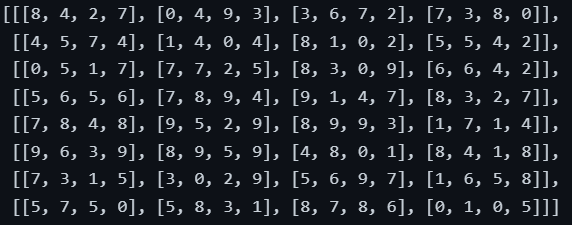

The reproduction value would be a value $R_{ij} $ with two indexes representing the number of subvectors $i$ and the centroid position $j$. Further, these values convert to a unique integer value.

Notebook Author: [Seyedsaman Emami](https://samanemami.github.io/)

<a id='PQperformance'></a>
## PQ performance
[Table of Contents](#Contents)

The product quantization needs a high-dimensional vector and breaks it into separated and same-size subvectors. We do have a centroid as well, but here for each subvector, there is one centroid (nearest one).

> We can observe that a large floating data type of a vector has transformed to and low size int with low memory usage.

<h5> Release Date: 29.Jun.2022 </h5>

If you want to have this method or use the outputs of the notebook, you can fork the Notebook as following (copy and Edit Kernel).

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1101107%2F8187a9b84c9dde4921900f794c6c6ff9%2FScreenshot%202020-06-28%20at%201.51.53%20AM.png?generation=1593289404499991&alt=media" alt="Copyandedit" width="300" height="300" class="center">

<hr>

##### You can find some of my developments [here](https://github.com/samanemami?tab=repositories).

<hr>

# Importing libraries
[Table of Contents](#Contents)

In [1]:
pip install nanopq

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import nanopq
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
import warnings
random_state = 123
np.random.seed(random_state)

warnings.simplefilter('ignore')

np.set_printoptions(precision=4, suppress=True)


sns.set_theme()

In [4]:
def make_pretty(styler):
    styler.set_caption("Weather Conditions")
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
    return styler

<a id='dt'></a>
# Importing dataset
[Table of Contents](#Contents)

The `RiverFlow-2` Dataset has 9125 instances and 576 features with eight continuous targets.

In [5]:
def dt(dataset):
    for dirname, _, _ in os.walk('/kaggle/input'):
        path = dirname
    path = os.path.join(path, dataset)
    df = arff.loadarff(path)
    df = pd.DataFrame(df[0])
    return df
df = dt("rf2.arff")
df.head().style.pipe(make_pretty)

<a id='Missing'></a>
## Missing values
[Table of Contents](#Contents)

##### Each new time-lagged attribute has the missing value equal to the lag

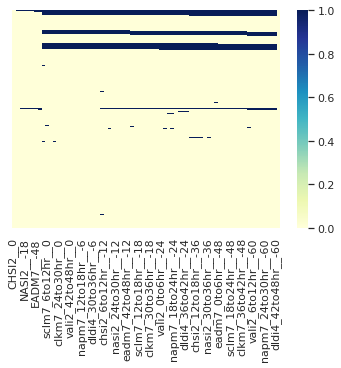

In [6]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap="YlGnBu")
plt.show()

In [7]:
df = df.dropna(axis=0)
print("Missing values:", df.isnull().sum(axis=1).sum())

Missing values: 0


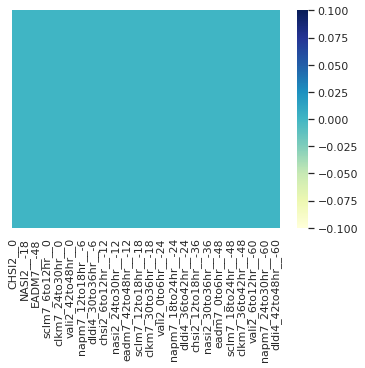

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap="YlGnBu")
plt.show()

<a id='Describe'></a>
## Describe the dataframe
[Table of Contents](#Contents)

In [9]:
df.describe().style.pipe(make_pretty)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7679 entries, 240 to 9124
Columns: 584 entries, CHSI2__0 to DLDI4_48H__0
dtypes: float64(584)
memory usage: 34.3 MB


<a id='Input'></a>
<a id='Scaling'></a>
## Model Input and Scaling
[Table of Contents](#Contents)


As we need to normalize the dataset or scale them, I considered the MinMaxScaler which scales the input dataset between zero and one range. 

Moreover, the datatype for the float should be 32.

In [11]:
def input(d):
    X = (df.iloc[:, :d]).values
    y = (df.iloc[:, d:]).values
    
    y = y.astype(np.float32)
    
    scale = MinMaxScaler()
    X = scale.fit_transform(X)

    return X, y

In [12]:
X, y = input(576)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

<a id='OutputQuantization'></a>
# Output Quantization
[Table of Contents](#Contents)


#### This study aims to quantize the output vector space (eight continuous regression targets).

Therefore, a multi-output regression with eight regression targets is converted to a multi-label classification with four discrete targets.

In [13]:
pq = nanopq.PQ(M=4, Ks=256, verbose=True)
pq.fit(vecs=y_train, iter=20, seed=random_state)

M: 4, Ks: 256, code_dtype: <class 'numpy.uint8'>
iter: 20, seed: 123
Training the subspace: 0 / 4
Training the subspace: 1 / 4
Training the subspace: 2 / 4
Training the subspace: 3 / 4


<a id='identifiers'></a>
## list of identifiers
[Table of Contents](#Contents)

Here the code words are the representers of the indices of the centroids of each sub-vector.

The code words would be treated as the discrete multi-label outputs  $h: X \rightarrow codewords $. The $h$ could be `RandomForest` Model.

In the training procedure of the quantization, I considered y_train for both training and encoding as the purpose is to predict the code words, hence the overfitting in the quantization problem is not the issue.

Author: [Seyedsaman Emami](https://samanemami.github.io/)

In [14]:
code_words = pq.encode(vecs=y_train)

Encoding the subspace: 0 / 4
Encoding the subspace: 1 / 4
Encoding the subspace: 2 / 4
Encoding the subspace: 3 / 4


### code_words

In [15]:
pq.fit(vecs=y_test, iter=20, seed=1)
code_words_test = pq.encode(vecs=y_test)

iter: 20, seed: 1
Training the subspace: 0 / 4
Training the subspace: 1 / 4
Training the subspace: 2 / 4
Training the subspace: 3 / 4
Encoding the subspace: 0 / 4
Encoding the subspace: 1 / 4
Encoding the subspace: 2 / 4
Encoding the subspace: 3 / 4


Here we can see the range of the allocated identifiers to each sub-vector (from zero to 250 unique IDs). The median is something between 100 and 150. And the size of quartiles is almost the same.

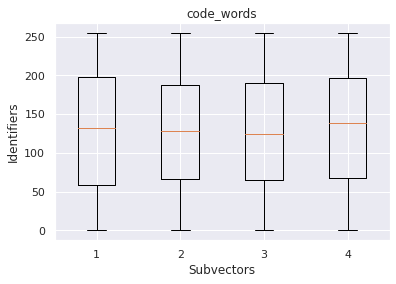

In [16]:
plt.boxplot(code_words)
plt.xlabel("Subvectors")
plt.ylabel("Identifiers")
plt.title("code_words")
plt.savefig("code_words.jpg")

6143 identifiers for each sub-vector and 130 as the average.

In [17]:
pd.DataFrame(code_words).describe().T.style.pipe(make_pretty)

,count,mean,std,min,25%,50%,75%,max
0,6143.000000,128.898584,76.591555,0.000000,58.500000,132.000000,198.000000,255.000000
1,6143.000000,126.528244,72.669482,0.000000,66.000000,128.000000,187.500000,255.000000
2,6143.000000,125.714472,72.924609,0.000000,65.000000,124.000000,190.000000,255.000000
3,6143.000000,132.711542,73.417652,0.000000,68.000000,138.000000,197.000000,255.000000


<a id='MultiLabelML'></a>
## Multi-Label classification problem
[Table of Contents](#Contents)

Using the subvector identifiers as the multi-label classification dependant variables.

In [18]:
model = RandomForestClassifier(max_depth=20,
                               max_features='sqrt',
                               n_estimators=100,
                               n_jobs=-1,
                               random_state=1,
                               verbose=1,
                               warm_start=True)

In [19]:
model.fit(x_train, code_words)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', n_jobs=-1,
                       random_state=1, verbose=1, warm_start=True)

Predicting the code words with the trained model.

In [20]:
pred = model.predict(x_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


<a id='Modelevaluation'></a>
## Model evaluation
[Table of Contents](#Contents)

<a id='withcodewords'></a>
### Model evaluation (with code words)
[Table of Contents](#Contents)

Here, I quantized the unseen batch of the output as well and used the prediction to return the R2 scores of different centroids (Four centroids).

> Note that this is the R2 Score for the identifiers and not the real values. For having a score of the real values we need to decode the subvectors (Predicted array).

Author: [Seyedsaman Emami](https://github.com/samanemami)

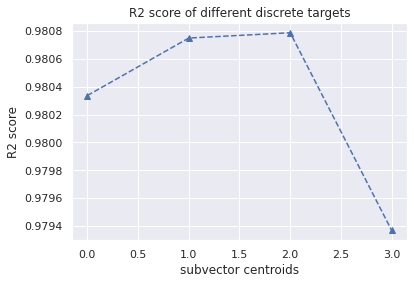

In [21]:
score = r2_score(code_words_test, pred, multioutput='raw_values')
plt.plot(score, linestyle="--", marker="^", )
plt.xlabel("subvector centroids")
plt.ylabel("R2 score")
plt.title("R2 score of different discrete targets")
plt.savefig("R2.jpg")

<a id='withrealvalues'></a>
### Model evaluation (Real values)
[Table of Contents](#Contents)

To reverse the code words and achieve the predicted continuous values, we decode the predicted values.

<a id='Decode'></a>
#### Decoding
[Table of Contents](#Contents)

In [22]:
pred_reconstructed = pq.decode(codes=pred)
print(pred_reconstructed.shape)

(1536, 8)


<a id='RMSE'></a>
#### RMSE
[Table of Contents](#Contents)

The selected metric for evaluating the regression performance is the Root Mean Square Error of different targets.

We can see that the RMSE satisfied the performance of the regression problem.

array([73.6104,  0.7323, 77.4572, 45.2171, 46.9124,  9.7391, 25.001 ,
       33.5098], dtype=float32)

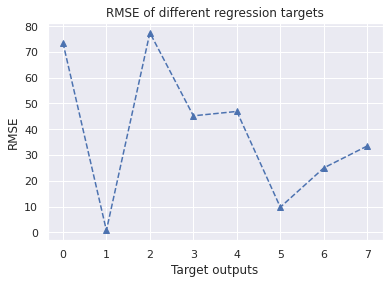

In [23]:
score = mean_squared_error(y_test,
                           pred_reconstructed,
                           multioutput='raw_values',
                           squared=False)

plt.plot(score, linestyle="--", marker="^", )
plt.xlabel("Target outputs")
plt.ylabel("RMSE")
plt.title("RMSE of different regression targets")
plt.savefig("RMSE.jpg")

score

<a id='Conclusion'></a>
# Conclusion
[Table of Contents](#Contents)

In this Notebook, I applied the purpose idea, of [[1]](#References). The idea was to transform the regression values into multi-dimensional subvectors with low precision integer types.

In this notebook, I used the following methods and metrics;
* Product Quantization
* Random Forest model
* R2 Score
* Root Mean Square Error
* Code words decoding

Author: [Seyedsaman Emami](https://samanemami.github.io/)

<a id='References'></a>
# References
[Table of Contents](#Contents)

1. Spyromitros-Xioufis, Eleftherios, Konstantinos Sechidis, and Ioannis Vlahavas. "Multi-target regression via output space quantization." 2020 International Joint Conference on Neural Networks (IJCNN). IEEE, 2020.

2. H. Jégou, M. Douze and C. Schmid, "Product Quantization for Nearest Neighbor Search," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 33, no. 1, pp. 117-128, Jan. 2011, doi: 10.1109/TPAMI.2010.57.
